`Kaggle Practice`
- https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques


`Practice Skils`
- Creative feature engineering
- Advanced regression techniques like random forest and gradient boosting


`Problem Framing`
- Problem: predict SalePrice
- Metric: RMSLE (Root Mean Squared Logarithmic Error)
- Train model on log1p(SalePrice) and Evaluate RMSE in log space (approximately RMSLE)


 `Key Takeaways`

 - Clean EDA decisions
 - Proper handling of missing values, categorical variables
 - Data leakage prevention: all preprocessing inside CV via Pipeline
 - Strong baseline model + Stronger models
 - End-to-end problem solution + Clear comments + Production considerations

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

### Data Overview

In [ ]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
# Data shpe
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (1460, 81)
Test Shape: (1459, 80)


In [4]:
# Duplicated rows
print("Duplicated Rows in Train:", train.duplicated().sum())

Duplicated Rows in Train: 0


In [5]:
# Data Dtypes Count
target_col = "SalePrice"
train.dtypes.value_counts()
train.drop(target_col, axis=1).dtypes.value_counts()

,count
object,43
int64,34
float64,3


In [6]:
numeric_features = list(train.drop(target_col, axis=1).select_dtypes(["float64", "int64"]).columns)
categorical_features = list(train.drop(target_col, axis=1).select_dtypes(["O"]).columns)

### Target Distribution + Why Log1p

- Prices are typically right‑skewed. If we fit directly on price with MSE/RMSE, very expensive homes dominate the loss.  
- Training on `log1p(SalePrice)` compresses the long tail, makes errors more “relative‑percentage like”, and aligns with RMSLE.

In [7]:
y = train["SalePrice"]
y.describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


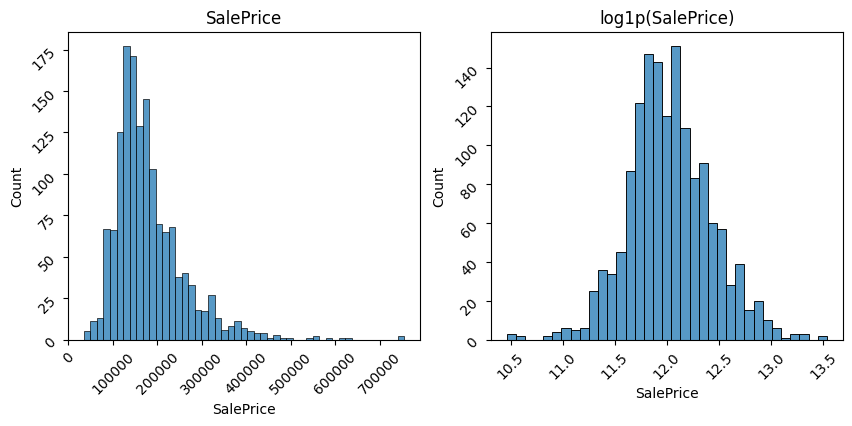

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(y, ax=axes[0])
axes[0].set_title("SalePrice")
axes[0].tick_params(rotation=45)

### After compressing the long tail using log1p
sns.histplot(np.log1p(y), ax=axes[1])
axes[1].set_title("log1p(SalePrice)")
axes[1].tick_params(rotation=45)
plt.show()

In [9]:
print("Before applying log1p, the skewness of y is:", round(y.skew(),2 ))
print("After applying log1p, the skewness of y is:", round(np.log1p(y).skew(), 2))

Before applying log1p, the skewness of y is: 1.88
After applying log1p, the skewness of y is: 0.12


### Missing Values (EDA Decision -> Pipeline Strategy)

In production, missingness can mean:
- True unknown (data collection gaps)
- Not applicable (e.g., no pools -> PoolQC should be "None")

I will keep EDA lightweight here, then handling missing values systematically in preprocessing.

In [10]:
missing_rate = train.isna().mean().sort_values(ascending=False)
missing_rate = missing_rate[missing_rate > 0].reset_index()
missing_rate.columns = ["Category", "Missing Rate"]
missing_rate.head()

,Category,Missing Rate
0,PoolQC,0.995205
1,MiscFeature,0.963014
2,Alley,0.937671
3,Fence,0.807534
4,MasVnrType,0.597260


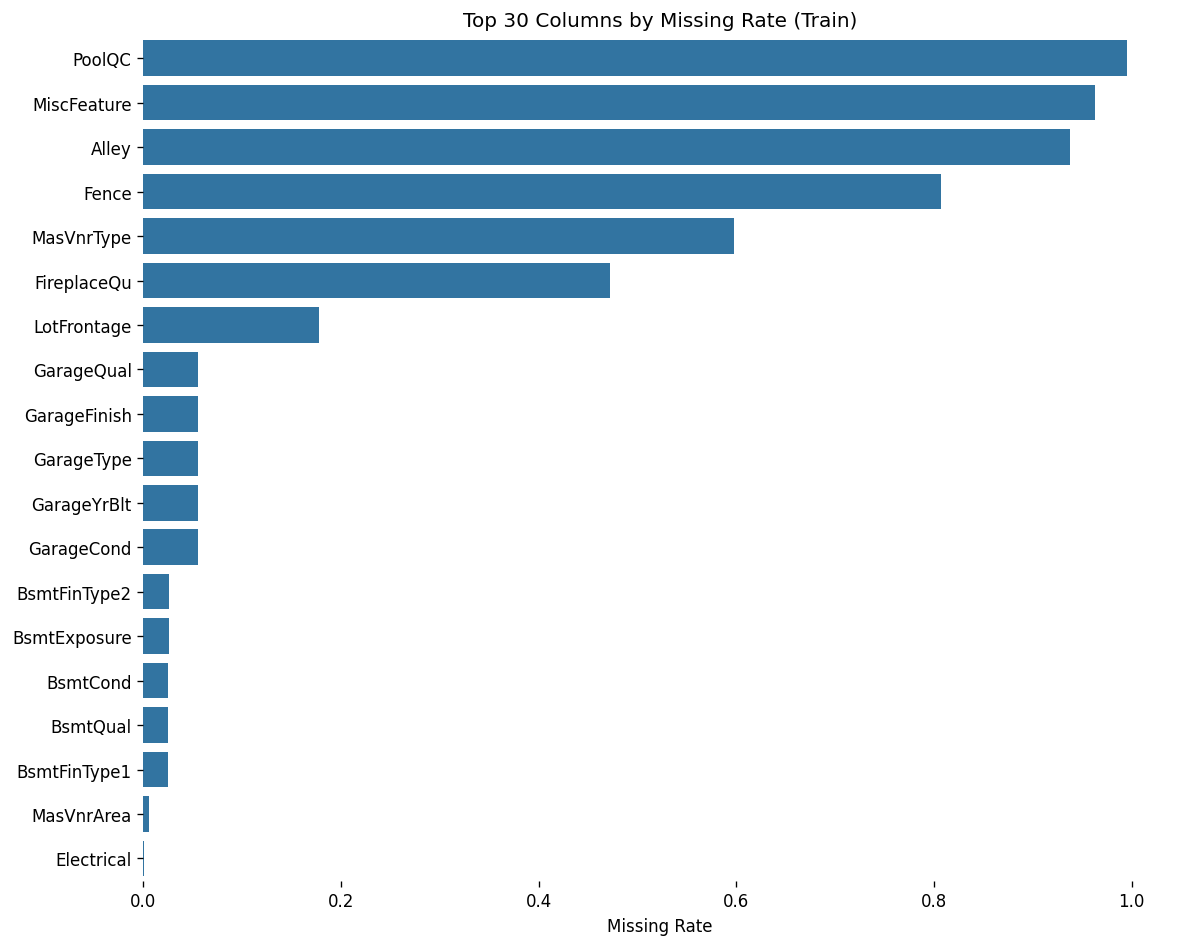

In [11]:
top = (missing_rate
       .sort_values("Missing Rate", ascending=False)
       .head(30)
       .copy())

plt.figure(figsize=(10, 8), dpi=120)
ax = sns.barplot(
    data=top,
    y="Category",
    x="Missing Rate",
    orient="h"
)
ax.set_title("Top 30 Columns by Missing Rate (Train)")
ax.set_xlabel("Missing Rate")
ax.set_ylabel("")

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


### Outliers Handling (MAD) - Optional

- Outlier Handling is not always mandatory
- Rule-based method: Mean Absolute Deviation (MAD)
- Remove only a small number of clearly extreme points
- Detect using X only (avoid target leakage)

In [12]:
def mad_based_outlier_mask(s: pd.Series, thresh: float = 6.0) -> pd.Series:
    '''
    Return a boolean mask indicating outliers using a MAD-based modified z-score.

    Modified z-score: z = 0.6745 * (x - median) / MAD
    - MAD is robust to outliers (uses median)
    - thresh ~ 6.0 is a common conservative cutoff
    '''
    x = s.astype(float).to_numpy()
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad == 0 or np.isnan(mad):
        return pd.Series(False, index=s.index)
    z = 0.6745 * (x - med) / mad
    return pd.Series(np.abs(z) > thresh, index=s.index)

candidate_outlier_cols = [c for c in ["GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea"] if c in train.columns]
candidate_outlier_cols

['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea']

In [13]:
X_train_raw = train.drop(columns=["SalePrice"]).copy()

outlier_mask_any = pd.Series(False, index=X_train_raw.index)
for c in candidate_outlier_cols:
    outlier_mask_any |= mad_based_outlier_mask(X_train_raw[c], thresh=6.0)

print("Detected outliers (any selected col):", int(outlier_mask_any.sum()))

train_clean = train.loc[~outlier_mask_any].reset_index(drop=True)
print("Before outlier removal:", train.shape)
print("After outlier removal:", train_clean.shape)

Detected outliers (any selected col): 6
Before outlier removal: (1460, 81)
After outlier removal: (1454, 81)


### Feature Engineering

I add a few standard features:
- TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF `(Total Finished Area)`
- HouseAge = YrSold - YearBuilt `(House Age at sale time)`
- RemodAge = YrSold - YearRemodAdd `(Years since Remodel)`
- Presence flags: HasBasement / HasGarage / HasPool `(Binary Flags for Presence of Basement/ Garage/ Pool)`

In [14]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    for col in ["TotalBsmtSF", "1stFlrSF", "2ndFlrSF"]:
        if col not in df.columns:
            df[col] = 0

    df["TotalSF"] = (
        df["TotalBsmtSF"].fillna(0) + df["1stFlrSF"].fillna(0) + df["2ndFlrSF"].fillna(0)
    )

    if "YrSold" in df.columns and "YearBuilt" in df.columns:
        df["HouseAge"] = (df["YrSold"] - df["YearBuilt"]).clip(lower=0)

    if "YrSold" in df.columns and "YearRemodAdd" in df.columns:
        df["RemodAge"] = (df["YrSold"] - df["YearRemodAdd"]).clip(lower=0)

    if "TotalBsmtSF" in df.columns:
        df["HasBasement"] = (df["TotalBsmtSF"].fillna(0) > 0).astype(int)
    if "GarageArea" in df.columns:
        df["HasGarage"] = (df["GarageArea"].fillna(0) > 0).astype(int)
    if "PoolArea" in df.columns:
        df["HasPool"] = (df["PoolArea"].fillna(0) > 0).astype(int)

    bath_cols = [c for c in ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"] if c in df.columns]
    if len(bath_cols) > 0:
        df["TotalBath"] = (
            df.get("FullBath", 0).fillna(0)
            + 0.5 * df.get("HalfBath", 0).fillna(0)
            + df.get("BsmtFullBath", 0).fillna(0)
            + 0.5 * df.get("BsmtHalfBath", 0).fillna(0)
        )

    return df

X_train = add_features(train_clean.drop(columns=[target_col]))
X_test = add_features(test)
y_log = np.log1p(train_clean[target_col])

print("X shape     :", X_train.shape)
print("X_test shape:", X_test.shape)

X shape     : (1454, 87)
X_test shape: (1459, 87)


### Correlation (Numerical Features Only) - Quick Sanity Check

In [15]:
X_train.dtypes.value_counts()

,count
object,43
int64,40
float64,4


In [16]:
num_tmp = X_train.select_dtypes(include=["int64", "float64"]).copy()
num_tmp["SalePrice_log"] = y_log.to_numpy()

corr = (
    num_tmp.corr()["SalePrice_log"]
    .drop(["SalePrice_log"])
    .sort_values(ascending=False)
)

display(corr.head(15))

,SalePrice_log
TotalSF,0.823420
OverallQual,0.818897
GrLivArea,0.720426
GarageCars,0.680423
TotalBath,0.673098
GarageArea,0.656250
TotalBsmtSF,0.642223
1stFlrSF,0.612718
FullBath,0.591784
YearBuilt,0.587254


<Axes: >

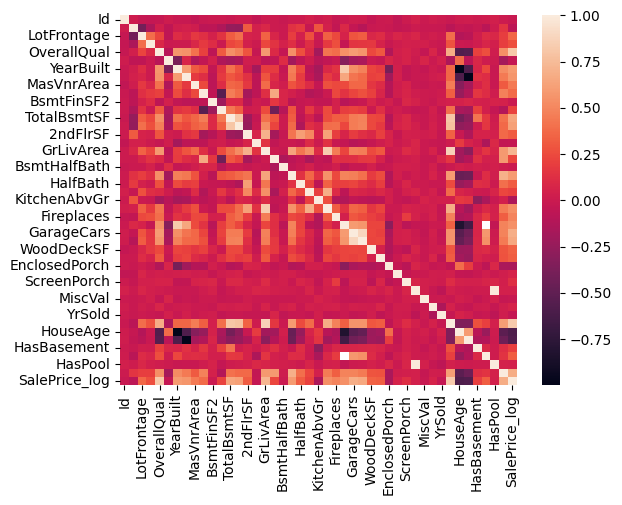

In [17]:
sns.heatmap(num_tmp.corr())

### Modeling Pipelines

I wrap preprocessing and modeling in a Pipeline so that during cross-validation, the imputer and encoder are fit only on the training fold, preventing leakage. And I set handle_unknown='ignore' so the one-hot encoder won’t crash when test data contains categories not seen in training.


🌟 What the pipeline fixes:
- Fit preprocessing only on the training fold
- Transform validation fold using those fitted rules
- Train model on transformed training fold
- Evaluate on transformed validation fold

✔️ Overall, the CV behaves like "real deployment": preprocess rules come only from training data. There won't be any data leakage, where information from the validation fold (or the test set) would influence how we preprocess the training fold.

❌ Example of data leakage (common mistakes): the impultation and onehotencoder use all the training data, including those that should have been "held out" in each fold.

## Preprocessing: Numeric + Ordinal + Nomial

- Nominal categories: One-Hot (handle_unknown='ignore')
- A small set of 'quality' categories: Ordinal encoding with a known order

***One-hot Encoding:***

- One-hot encoding uses handle_unknow='ignore' to safely handle categories present in test but not train.

Explanation: Categorical columns can have categories that: 1) exist in train but not in test. 2) exist in test but no in train. Without setting handle_unknown='ignore', when we call transform(test), there will be error like "Found unknown categories".

- handle-unknown='ignore' tells OneHotEncoder:
- If a category appears during transform that wasn’t seen during fit, don’t crash
- Just encode it as all zeros for that feature’s one-hot columns (meaning “none of the known categories”)

In [18]:
numeric_cols = X_train.select_dtypes(exclude=["O"]).columns.to_list()

# Remove Id
numeric_cols = [c for c in numeric_cols if c != "Id"]
numeric_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'TotalSF',
 'HouseAge',
 'RemodAge',
 'HasBasement',
 'HasGarage',
 'HasPool',
 'TotalBath']

In [19]:
cat_cols = X_train.select_dtypes(include=["O"]).columns.to_list()
cat_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [20]:
cat_col_values = {}
for cat in cat_cols:
  cat_col_values[cat] = set((X_train[cat]))
# cat_col_values

In [21]:
ordinal_cols = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC",
    "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"
]
quality_scale = ["None", "Po", "Fa", "TA", "Gd", "Ex"] # worst -> best
nominal_cols = list(set(cat_cols) - set(ordinal_cols))

print("Numerical Cols:", numeric_cols)
print("Ordinal Category Cols:", ordinal_cols)
print("Nominal Category Cols:", nominal_cols)

Numerical Cols: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF', 'HouseAge', 'RemodAge', 'HasBasement', 'HasGarage', 'HasPool', 'TotalBath']
Ordinal Category Cols: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
Nominal Category Cols: ['SaleType', 'Condition1', 'Electrical', 'BsmtExposure', 'RoofMatl', 'BldgType', 'Fence', 'CentralAir', 'LandSlope', 'SaleCondition', 'Foundation', 'Neighborhood', 'Exterior2nd', 'LotShape', 'LandContour', 'BsmtFinType

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

ordinal_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("ord", OrdinalEncoder(
        categories=[quality_scale] * len(ordinal_cols),
        handle_unknown="use_encoded_value",
        unknown_value=-1
    )),
])

nominal_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("ord", ordinal_pipe, ordinal_cols),
        ("cat", nominal_pipe, nominal_cols),
    ],
    remainder="drop",
)

## Model Comparison with Cross-Validation
- Dummy Baseline (mean)
- Regularized Linear Models
- Histogram Gradient Boosting (Strong non-linear baseline model in sklearn)

Scoring: RMSE on log1p(SalePrice)

In [23]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline

N_SPLITS = 5
RANDOM_STATE = 42

def rmse_cv(model, X, y_log, n_splits=N_SPLITS, random_state=RANDOM_STATE):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    scores = cross_val_score(pipe, X, y_log, scoring="neg_root_mean_squared_error", cv=cv)
    return -scores

models = {
    "Dummy(mean)": DummyRegressor(strategy="mean"),
    "Ridge(alpha=10)": Ridge(alpha=10, random_state=RANDOM_STATE),
    "Lasso(alpha=5e-4)": Lasso(alpha=5e-4, random_state=RANDOM_STATE, max_iter=5000),
    "ElasticNet(a=5e-4,l1=0.2)": ElasticNet(alpha=5e-4, l1_ratio=0.2, random_state=RANDOM_STATE, max_iter=5000),
    "HistGBR": HistGradientBoostingRegressor(random_state=RANDOM_STATE),
}

rows = []
for name, m in models.items():
    scores = rmse_cv(m, X_train, y_log)
    rows.append((name, float(scores.mean()), float(scores.std())))

cv_summary = pd.DataFrame(rows, columns=["model", "rmse_log_mean", "rmse_log_std"]).sort_values("rmse_log_mean")
display(cv_summary)

,model,rmse_log_mean,rmse_log_std
2,Lasso(alpha=5e-4),0.111642,0.015374
1,Ridge(alpha=10),0.112707,0.015537
3,"ElasticNet(a=5e-4,l1=0.2)",0.113731,0.014736
4,HistGBR,0.125925,0.012390
0,Dummy(mean),0.395531,0.020134


## Model Tuning

In [24]:
from sklearn.model_selection import GridSearchCV

cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
scoring = "neg_root_mean_squared_error"

lasso_pipe = Pipeline(
    steps=[
        ("prep", preprocess),
         ("model", Lasso(random_state=RANDOM_STATE, max_iter=10000))])
lasso_grid = {"model__alpha": [1e-4, 3e-4, 5e-4, 1e-3, 3e-3]}

gbr_pipe = Pipeline(
    steps=[("prep", preprocess),
     ("model", HistGradientBoostingRegressor(random_state=RANDOM_STATE))])
gbr_grid = {
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [3, None],
    "model__max_leaf_nodes": [31, 63],
}

lasso_search = GridSearchCV(lasso_pipe, lasso_grid, cv=cv, scoring=scoring, n_jobs=-1)
gbr_search = GridSearchCV(gbr_pipe, gbr_grid, cv=cv, scoring=scoring, n_jobs=-1)

lasso_search.fit(X_train, y_log)
gbr_search.fit(X_train, y_log)

print("Best Lasso   :", lasso_search.best_params_, "RMSE(log):", -lasso_search.best_score_)
print("Best HistGBR :", gbr_search.best_params_, "RMSE(log):", -gbr_search.best_score_)

best_search = gbr_search if (-gbr_search.best_score_ <= -lasso_search.best_score_) else lasso_search
best_pipe = best_search.best_estimator_
print("\nSelected best model:", type(best_pipe['model']).__name__)

Best Lasso   : {'model__alpha': 0.0005} RMSE(log): 0.11164216718557021
Best HistGBR : {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__max_leaf_nodes': 31} RMSE(log): 0.12235427538816271

Selected best model: Lasso


## Fit on full train + Create Submission

In [25]:
best_pipe.fit(X_train, y_log)
test_pred_log = best_pipe.predict(X_test)
test_pred = np.expm1(test_pred_log)

submission = pd.DataFrame({"Id": test["Id"], "SalePrice": test_pred})
display(submission.head())

out_path = "submission.csv"
submission.to_csv(out_path, index=False)
print("Saved:", out_path, "rows:", len(submission))

,Id,SalePrice
0,1461,119187.750807
1,1462,152139.951340
2,1463,177451.237758
3,1464,199288.938262
4,1465,190459.174673


Saved: submission.csv rows: 1459


## ML Model Deployment/ Production

What to do to ship the product safely in a production environment?

**1. Packaging & reproducibility**

- Single sklearn Pipeline (preprocess + model) saved with versioning (joblib/MLflow), so training and inference are identical.

- Pin Python + library versions, record feature schema (names + dtypes), and store training metadata (data snapshot hash, code commit SHA).

-  Deterministic runs: set random_state, log CV splits, seed any sampling.

**2. Data contracts & feature generation**

- Define a feature contract: required columns, allowed null rates, category handling, and units.

- Implement schema validation at inference (e.g., Great Expectations / pandera): fail fast or fallback.

- For categorical drift: handle_unknown="ignore" (OHE) or unknown_value=-1 (Ordinal) + monitor “unknown rate”.

**3. Serving pattern**

- Choose based on product need: 1) Batch scoring (daily/ hourly) if decisions don’t need real-time. 2) Online scoring via a small service (FastAPI) if you need “decision in milliseconds”.

- Use a feature store or at least a consistent feature computation layer so offline/online parity holds.

**4. Monitoring & alerting (what you watch after launch)**

- Data quality: missing rate, out-of-range checks, unknown-category rate.

- Distribution drift: PSI/KS on key features + prediction drift.

- Performance: 1) For regression: MAE/RMSE on recent backfilled outcomes, plus segment-level error. 2) For uplift/offer targeting: business KPIs (CTR, conversion, revenue/user) and guardrails. Calibration if you output probabilities/expected value for decisioning.

**5. Retraining & rollout strategy**
- Set retrain triggers: time-based (weekly/monthly) + drift-based.

- Use champion/challenger: new model runs in shadow, compare online metrics.

- Safe rollout: canary (small % traffic), then ramp up. Always keep rollback path.

**6. Experimentation & causality**

- Don’t trust offline “lift” alone—use A/B tests or holdouts.

- Predefine success metrics, sample size / power, and guardrails (unsubscribe, complaint rate, latency).

- For personalization: add constraints (frequency caps, fatigue, fairness) to avoid over-messaging.

**7. Privacy, security, compliance**

- Minimize PII in features; use hashed IDs, least-privilege access, encryption at rest/in transit.

- Respect retention and consent (GDPR/CCPA style), audit logs, and explain how features are derived.

**8. Latency & cost considerations**

- Keep inference lightweight: limit one-hot explosion, consider hashing/target encoding (with leakage-safe CV), or pruning rare categories.

- Cache static features; separate “slow” feature computation from “fast” scoring.